# COVID-19 USA

## Objetivos deste notebook

Adaptar o [notebook](https://raw.githubusercontent.com/jgrocha/covid-pt/master/Casos%20de%20estudo/COVID-19_USA_statistics/COVID-19_USA_statistics.ipynb) criado por Tiago Pinheiro - A82491 de forma a utilizar dados mais atualizados.

In [1]:
import sys
import os
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *
from IPython.display import Image

Start Qgis with GUI and start a project

In [2]:
qgis_path = r"C:\OSGeo4W64\apps\qgis"
QgsApplication.setPrefixPath(qgis_path, True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r"C:\OSGeo4W64\apps\qgis\python\plugins")
project = QgsProject.instance()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:\OSGeo4W64\apps\qgis/./svg/
		C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/Marcelo/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/Marcelo/AppData/Roaming/python3\profiles\default/qgis-auth.db



Download Map

In [3]:
import urllib.request
url = 'https://data.biogeo.ucdavis.edu/data/diva/adm/AUT_adm.zip'
filename = 'AUT_adm.zip'
urllib.request.urlretrieve(url, filename)

('AUT_adm.zip', <http.client.HTTPMessage at 0x2499df6d0b8>)

Unzip Map

In [4]:
import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

Load map layer

In [5]:
path = "AUT_adm1.shp"
map_layer = QgsVectorLayer(path, 'AUSTRIA map', 'ogr')

if not map_layer.isValid():
    print("Failed to load the layer!")
else:
    project.addMapLayer(map_layer)
    print("Sucess")

Sucess


Download csv file

In [6]:
import urllib.request
url = 'https://raw.githubusercontent.com/covid19-eu-zh/covid19-eu-data/master/dataset/covid-19-at.csv'
filename = 'covid-19-at.csv'
urllib.request.urlretrieve(url, filename)

('covid-19-at.csv', <http.client.HTTPMessage at 0x2499df6df98>)

In [79]:
import csv
import datetime
from datetime import date

today = date.today()
today = today.strftime("%m/%d/%Y")
print("Today's date:", today)

safe_date = date.today()-datetime.timedelta(2)
safe = safe_date.strftime("%y-%m-%d")
print("Safe date:", safe)




with open('covid-19-at.csv', 'r') as i, open('covid-19-austria.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
    #for row in r:
    #    if row[8] == "2020-05-09T15:00:00": 
    #        writer.writerow(row)
    #        print(row)
            
    for row in r:
        if safe in row[8]: 
            writer.writerow(row)
            print("this: ", row)

Today's date: 05/28/2020
Safe date: 20-05-26
this:  ['AT', 'Burgenland', '341', '320', '11', '11416', '2', '0', '2020-05-26T08:00:00']
this:  ['AT', 'KÃ¤rnten', '411', '396', '13', '15255', '0', '0', '2020-05-26T08:00:00']
this:  ['AT', 'Vorarlberg', '898', '864', '19', '19543', '0', '0', '2020-05-26T08:00:00']
this:  ['AT', 'Salzburg', '1221', '1193', '38', '31932', '2', '0', '2020-05-26T08:00:00']
this:  ['AT', 'Steiermark', '1835', '1605', '145', '46349', '7', '1', '2020-05-26T08:00:00']
this:  ['AT', 'OberÃ¶sterreich', '2290', '2204', '60', '57222', '9', '1', '2020-05-26T08:00:00']
this:  ['AT', 'NiederÃ¶sterreich', '2847', '2604', '100', '58868', '32', '11', '2020-05-26T08:00:00']
this:  ['AT', 'Wien', '3098', '2553', '147', '95237', '74', '14', '2020-05-26T08:00:00']
this:  ['AT', 'Tirol', '3535', '3399', '108', '69519', '13', '4', '2020-05-26T08:00:00']
this:  ['AT', '', '16476', '15138', '641', '405341', '139', '31', '2020-05-26T08:00:00']
this:  ['AT', 'Burgenland', '341', '32

Load csv file

In [8]:
csv_path = "file:covid-19-austria.csv?delimiter=(',')"
csv_layer = QgsVectorLayer(csv_path, 'Data', 'delimitedtext')

if not csv_layer.isValid():
    print('Layer failed to load!')
else:
    project.addMapLayer(csv_layer)
    print("Sucess")

Sucess


Join layer

In [9]:
joinName = 'name'
targetName = 'NAME_1'

joinObject = QgsVectorLayerJoinInfo()
joinObject.setJoinFieldName(joinName)
joinObject.setTargetFieldName(targetName)
joinObject.setJoinLayerId(csv_layer.id())
joinObject.setUsingMemoryCache(True)
joinObject.setJoinLayer(csv_layer)
flag = map_layer.addJoin(joinObject)

## Gráfico do número de mortes, casos confirmados e casos recuperados

In [10]:
dict = []

for feature in map_layer.getFeatures():
    if feature['NAME_1']:
        state = feature['NAME_1']
        if feature['Data_deaths']:
            death = feature['Data_deaths']
        else:
            death = 0
        if feature['Data_cases']:
            confirmed = feature['Data_cases']
        else:
            confirmed = 0
        if feature['Data_recovered']:
            recovered = feature['Data_recovered']
        else:
            recovered = 0
        if feature['Data_tests']:
            tests = feature['Data_tests']
        else:
            tests = 0
        if feature['Data_hospitalized']:
            hospitalized = feature['Data_hospitalized']
        else:
            hospitalized = 0
        if feature['Data_intensive_care']:
            intensive_care = feature['Data_intensive_care']
        else:
            intensive_care = 0
        
    e = {'Name': state, 'Confirmed': confirmed, 'Death': death, 'Recovered': recovered, 'Tests': tests, 'Hospitalized': hospitalized, 'Intensive Care': intensive_care }
    dict.append(e)

In [11]:
size = len(dict)-5

c = sorted(dict, key = lambda i: i['Confirmed'],reverse=True)
d = sorted(dict, key = lambda i: i['Death'],reverse=True)
r = sorted(dict, key = lambda i: i['Recovered'],reverse=True)
t = sorted(dict, key = lambda i: i['Tests'],reverse=True)
h = sorted(dict, key = lambda i: i['Hospitalized'],reverse=True)
i = sorted(dict, key = lambda i: i['Intensive Care'],reverse=True)

top5confirmed = c[0:5]
top5death = d[0:5]
top5recovered = r[0:5]
top5tests = t[0:5]
top5hospitalized = h[0:5]
top5intensive_care = i[0:5]

bottom5confirmed = c[size:]
bottom5death = d[size:]
bottom5recovered = r[size:]
bottom5tests = r[size:]
bottom5hospitalized = h[size:]
bottom5intensive_care = i[size:]

### Top 5 Casos Confirmados

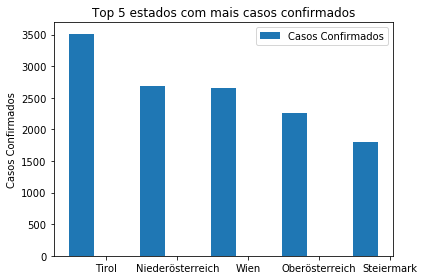

In [12]:
delta1 = [top5confirmed[0]['Confirmed'],top5confirmed[1]['Confirmed'],top5confirmed[2]['Confirmed'],top5confirmed[3]['Confirmed'],top5confirmed[4]['Confirmed']]
states = [top5confirmed[0]['Name'],top5confirmed[1]['Name'],top5confirmed[2]['Name'],top5confirmed[3]['Name'],top5confirmed[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos Confirmados')

plt.ylabel('Casos Confirmados')
plt.title('Top 5 estados com mais casos confirmados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Casos Confirmados

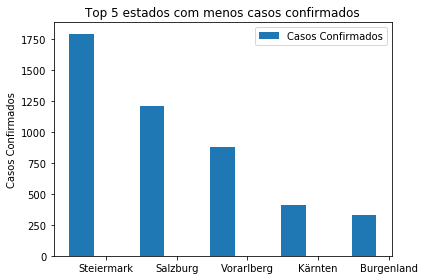

In [13]:
delta1 = [bottom5confirmed[0]['Confirmed'],bottom5confirmed[1]['Confirmed'],bottom5confirmed[2]['Confirmed'],bottom5confirmed[3]['Confirmed'],bottom5confirmed[4]['Confirmed']]
states = [bottom5confirmed[0]['Name'],bottom5confirmed[1]['Name'],bottom5confirmed[2]['Name'],bottom5confirmed[3]['Name'],bottom5confirmed[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos Confirmados')

plt.ylabel('Casos Confirmados')
plt.title('Top 5 estados com menos casos confirmados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Top 5 Mortes

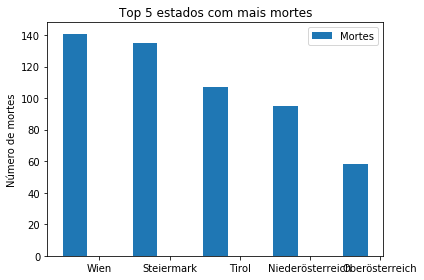

In [14]:
delta1 = [top5death[0]['Death'],top5death[1]['Death'],top5death[2]['Death'],top5death[3]['Death'],top5death[4]['Death']]
states = [top5death[0]['Name'],top5death[1]['Name'],top5death[2]['Name'],top5death[3]['Name'],top5death[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Mortes')

plt.ylabel('Número de mortes')
plt.title('Top 5 estados com mais mortes')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Mortes

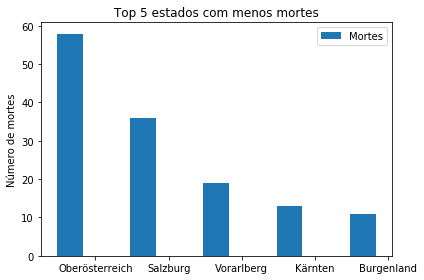

In [15]:
delta1 = [bottom5death[0]['Death'],bottom5death[1]['Death'],bottom5death[2]['Death'],bottom5death[3]['Death'],bottom5death[4]['Death']]
states = [bottom5death[0]['Name'],bottom5death[1]['Name'],bottom5death[2]['Name'],bottom5death[3]['Name'],bottom5death[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Mortes')

plt.ylabel('Número de mortes')
plt.title('Top 5 estados com menos mortes')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Top 5 Casos Recuperados

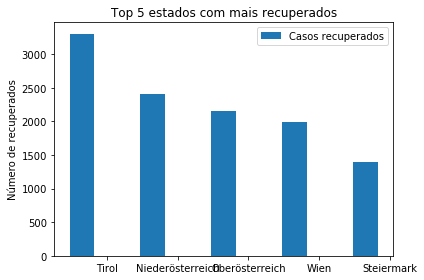

In [16]:
delta1 = [top5recovered[0]['Recovered'],top5recovered[1]['Recovered'],top5recovered[2]['Recovered'],top5recovered[3]['Recovered'],top5recovered[4]['Recovered']]
states = [top5recovered[0]['Name'],top5recovered[1]['Name'],top5recovered[2]['Name'],top5recovered[3]['Name'],top5recovered[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos recuperados')

plt.ylabel('Número de recuperados')
plt.title('Top 5 estados com mais recuperados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Casos Recuperados

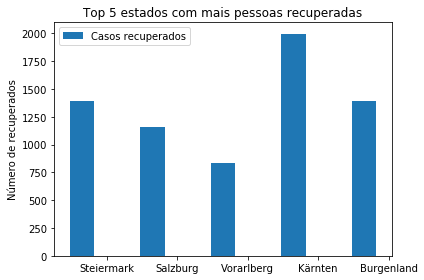

In [17]:
delta1 = [bottom5recovered[0]['Recovered'],bottom5recovered[1]['Recovered'],bottom5recovered[2]['Recovered'],top5recovered[3]['Recovered'],top5recovered[4]['Recovered']]
states = [bottom5recovered[0]['Name'],bottom5recovered[1]['Name'],bottom5recovered[2]['Name'],bottom5recovered[3]['Name'],bottom5recovered[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos recuperados')

plt.ylabel('Número de recuperados')
plt.title('Top 5 estados com mais pessoas recuperadas')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Top 5 Casos Testados

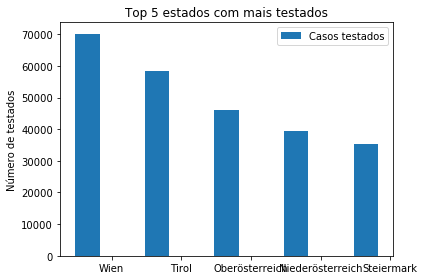

In [18]:
delta1 = [top5tests[0]['Tests'],top5tests[1]['Tests'],top5tests[2]['Tests'],top5tests[3]['Tests'],top5tests[4]['Tests']]
states = [top5tests[0]['Name'],top5tests[1]['Name'],top5tests[2]['Name'],top5tests[3]['Name'],top5tests[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos testados')

plt.ylabel('Número de testados')
plt.title('Top 5 estados com mais testados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

### Bottom 5 Casos Testados

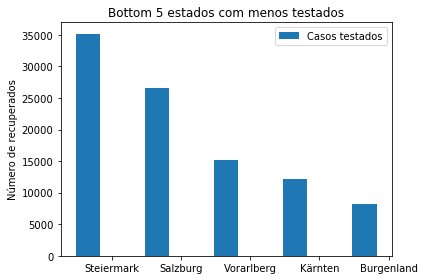

In [19]:
delta1 = [bottom5tests[0]['Tests'],bottom5tests[1]['Tests'],bottom5tests[2]['Tests'],bottom5tests[3]['Tests'],bottom5tests[4]['Tests']]
states = [bottom5tests[0]['Name'],bottom5tests[1]['Name'],bottom5tests[2]['Name'],bottom5tests[3]['Name'],bottom5tests[4]['Name']]

fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='Casos testados')

plt.ylabel('Número de recuperados')
plt.title('Bottom 5 estados com menos testados')
plt.xticks(index + bar_width,states,)
plt.legend()

plt.tight_layout()
plt.show()

## Taxa de Mortes

Criar uma nova camada para imprimir a taxa de mortalidade

In [67]:
death_layer = map_layer.clone()
death_layer.setName("Deaths")

for field in death_layer.fields():
    print("Column "+field.name()+" Load")

Column ID_0 Load
Column ISO Load
Column NAME_0 Load
Column ID_1 Load
Column NAME_1 Load
Column TYPE_1 Load
Column ENGTYPE_1 Load
Column NL_NAME_1 Load
Column VARNAME_1 Load
Column Data_country Load
Column Data_cases Load
Column Data_recovered Load
Column Data_deaths Load
Column Data_tests Load
Column Data_hospitalized Load
Column Data_intensive_care Load
Column Data_datetime Load


In [71]:
from qgis.utils import iface


label_settings = QgsPalLayerSettings()
label_settings.drawBackground = True
label_settings.fieldName = "Data_deaths"

text_format = QgsTextFormat()

text_format.setFont(QFont("Arial", 30))
text_format.setSize(55) 
                     
background_color = QgsTextBackgroundSettings()
text_format.setColor(QColor("white"))

background_color.setEnabled(False)
text_format.setBackground(background_color )
label_settings.setFormat(text_format)

death_layer.setLabeling(QgsVectorLayerSimpleLabeling(label_settings))
death_layer.setLabelsEnabled(True)
death_layer.triggerRepaint()

Criar os limites e a graduação das cores

In [72]:
from qgis.PyQt import QtGui

myOpacity = 1

myTargetField = 'Data_deaths'
myRangeList = []

myMin = 0
myMax = 10
myLabel = '0-10'
myColour = QtGui.QColor('#ffcccc')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 10
myMax = 20
myLabel = '10-20'
myColour = QtGui.QColor('#ff6666')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 300
myMax = 450
myLabel = '300 - 450'
myColour = QtGui.QColor('#ff3333')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)


myMin = 20
myMax = 40
myLabel = '20 - 40'
myColour = QtGui.QColor('#ff0000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 40
myMax = 60
myLabel = '40 - 60'
myColour = QtGui.QColor('#cc0000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 60
myMax = 80
myLabel = '60 - 80'
myColour = QtGui.QColor('#990000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 80
myMax = 100
myLabel = '80 - 100'
myColour = QtGui.QColor('#a51d00')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 100
myMax = 120
myLabel = '100-120'
myColour = QtGui.QColor('#660000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = 120
myMax = 150
myLabel = '120-150'
myColour = QtGui.QColor('5d0000')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)

myMin = -1
myMax = -1
myLabel = 'Sem Dados'
myColour = QtGui.QColor('#333333')
mySymbol = QgsSymbol.defaultSymbol(death_layer.geometryType())
mySymbol.setColor(myColour)
myRange = QgsRendererRange(myMin, myMax, mySymbol, myLabel)
myRangeList.append(myRange)
myRenderer = QgsGraduatedSymbolRenderer('', myRangeList)
myClassificationMethod = QgsApplication.classificationMethodRegistry().method("EqualInterval")
myRenderer.setClassificationMethod(myClassificationMethod)
myRenderer.setClassAttribute(myTargetField)

death_layer.setRenderer(myRenderer)

# COVID 19 DEATHS in AUSTRIA

In [73]:
xt = death_layer.extent()
width  = 1500
height = int(width*xt.height()/xt.width())

project = QgsProject().instance()
project.addMapLayers([death_layer])
manager = project.layoutManager()
layoutName = 'deaths'
layouts_list = manager.printLayouts()
for layout in layouts_list:
    if layout.name() == layoutName:
        manager.removeLayout(layout)
        
layout = QgsPrintLayout(project)
layout.initializeDefaults()
layout.setName(layoutName)
manager.addLayout(layout)




pc = layout.pageCollection()
pc.page(0).attemptResize(QgsLayoutSize(width,height,QgsUnitTypes.LayoutMillimeters))


map = QgsLayoutItemMap(layout)
map.setRect(20,20,20,20)
map.setLayers([death_layer])



ms = QgsMapSettings()
ms.setLayers([death_layer])
ms.setExtent(xt)
map.setExtent(xt)


layout.addLayoutItem(map)



map.attemptMove(QgsLayoutPoint(0,0,QgsUnitTypes.LayoutMillimeters))
map.attemptResize(QgsLayoutSize(width,height,QgsUnitTypes.LayoutMillimeters))


map.setBackgroundColor(QColor(250,250,250))




legend = QgsLayoutItemLegend(layout)

legend.setReferencePoint(6)
legend.setScale(3)
legend.attemptMove(QgsLayoutPoint(0,height,QgsUnitTypes.LayoutMillimeters))

layout.addLayoutItem(legend)
legend.setLegendFilterByMapEnabled(True)

legend.setLinkedMap(map)

exporter = QgsLayoutExporter(manager.layoutByName("deaths"))


image = exporter.renderPageToImage(0)
image = exporter.renderPageToImage(0)

from IPython.display import Image
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
image.save('Deaths_austria.png',"PNG")
Image( imgbuf.data() )